## Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import altair as alt
import matplotlib as plt
import seaborn as sns
import geopandas as gpd
import datetime
from geopy import distance

## Read in data

In [2]:
tmp = pd.read_csv('data/elwha.cleaned.2000-2023.csv')

In [3]:
len(tmp)

15548295

In [3]:
site_names = pd.read_excel("data/Temperature Site Names.xlsx", "Master")

In [4]:
elwha_streams = gpd.read_file('data/shapefiles/elwha_streams/elwha_streams.shp')

In [6]:
# #Create empty dataframe
# tpreds = pd.DataFrame()

# #Iterate over directory to get all files
# for child in Path('data/st_pred_171100').iterdir():
#     if child.is_file():
#         tpreds = pd.concat([tpreds, pd.read_csv('data/st_pred_171100/' + f"{child.name}")])

## Look at contents of data frames

In [7]:
#tmp.info()

In [8]:
#site_names.head()

In [9]:
#tmp.head()

In [10]:
#tpreds

## Data Filtering to One Year

In [11]:
tmp['year'] = tmp['DateTime'].apply(lambda x: x[:4]).astype(int)

In [12]:
small_tmp = tmp.loc[tmp['year'] == 2023]

In [13]:
len(small_tmp)

117771

## Aggregate Data by Time

In [14]:
#Get just date from date time
tmp['Date'] = tmp['DateTime'].apply(lambda x: x.split('T')[0])

#Get just the month from date
tmp['Month'] = tmp['Date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])

In [15]:
#Convert to date time format
tmp['Date'] = tmp['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
tmp['Month'] = tmp['Month'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

In [16]:
#tmp.head(-5)

In [17]:
tmp_grouped = tmp[['Month', 'Temp']].groupby(['Month']).mean().reset_index()

In [18]:
#tmp_grouped.head()

In [19]:
#tmp_grouped.to_csv('daily-avg-tmp-23.csv', index = False)

Text(0.5, 1.0, 'Average Monthly Temperature')

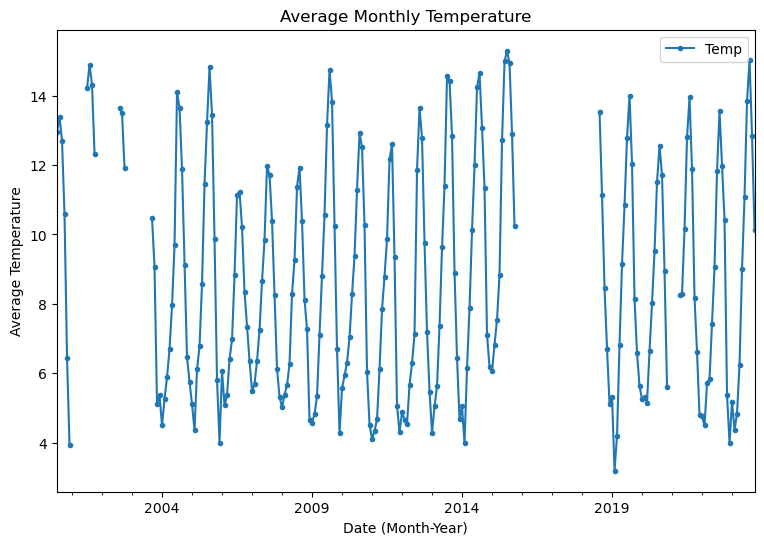

In [20]:
ax = tmp_grouped.plot(x='Month', y= 'Temp', marker='.', figsize=(9, 6))
ax.set_xlabel('Date (Month-Year)')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Monthly Temperature')
#ax.get_figure().savefig('AvgMonthly.png')

## Missing Data

In [21]:
tmp['Temp'].isna().sum()/len(tmp)

0.9224094989193349

In [22]:
#Calculate percentage of NA values per site
sites = tmp['Site'].unique()
pct_na = []
for site in sites:
    pct_na.append({
        'Site' : site,
        'pct_na':tmp.loc[tmp['Site'] == site, 'Temp'].isna().sum()/len(tmp.loc[tmp['Site'] == site, :])
    })
pct_na = pd.DataFrame(pct_na)

In [23]:
#Calculate percentage of NA values per day
dates = tmp['Date'].unique()
pct_na_date = []
for day in dates:
    pct_na_date.append({
        'Date' : day,
        'pct_na_dates':tmp.loc[tmp['Date'] == day, 'Temp'].isna().sum()/len(tmp.loc[tmp['Date'] == day, :])
    })
pct_na_date = pd.DataFrame(pct_na_date)

In [24]:
#pct_na.info()

Text(0.5, 1.0, 'Missing Data by Date')

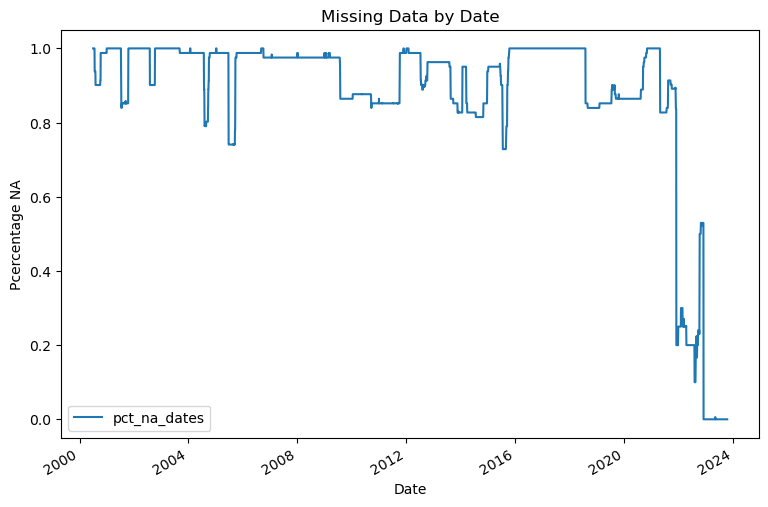

In [25]:
ax = pct_na_date.plot(x='Date', y= 'pct_na_dates', figsize=(9, 6))
ax.set_xlabel('Date')
ax.set_ylabel('Pcercentage NA')
ax.set_title('Missing Data by Date')
#ax.get_figure().savefig('MissingbyDate.png')

Text(0.5, 1.0, 'Missing Data by Site')

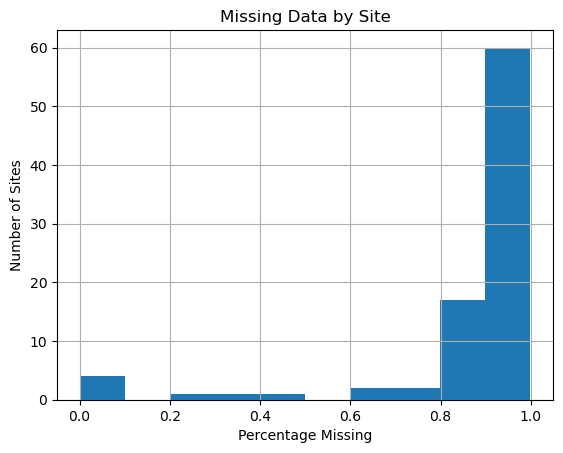

In [26]:
ax = pct_na['pct_na'].hist()
ax.set_xlabel('Percentage Missing')
ax.set_ylabel('Number of Sites')
ax.set_title('Missing Data by Site')
#ax.get_figure().savefig('MissingbySite.png')

In [27]:
pct_na.loc[pct_na['pct_na'] < 0.75]

,Site,pct_na
9,MS11,0.698353
68,IC02,0.614920
76,LR02,0.476889
81,MS16-5,0.382999
82,LS01,0.246870
84,MS00,0.000000
85,MS01,0.000000
86,ES01,0.000000
87,ES02,0.000000


In [28]:
#

In [38]:
#Color map of missing data
streams_chart = alt.Chart(elwha_streams).mark_geoshape(
    stroke = 'black', fill = 'none'
).project(
    type='mercator'
)

sites_chart = alt.Chart(site_names).mark_circle().encode(
    longitude='LONG:Q',
    latitude='LAT:Q',
    color = alt.Color('pct_na:Q').scale(scheme="lightorange"),
    size=alt.value(50),
).transform_lookup(
    lookup='Temp_Alias',
    from_=alt.LookupData(pct_na, 'Site', ["pct_na"])
).project(
    "mercator"
).properties(
    width = 500,
    height= 1000
)

missingdata = alt.layer(streams_chart, sites_chart)
missingdata.save('missingmap.png')

## Active Sites

In [5]:
#Get a list of the names of active sites
active_sites = list(site_names.loc[site_names['Monitoring'].notna()]['Temp_Alias'].unique())

In [6]:
#Percentage of NA for all sites
tmp['Temp'].isna().sum()/len(tmp)

0.9224094989193349

In [7]:
#Check percent NA for active sites only
tmp.loc[tmp['Site'].isin(active_sites)]['Temp'].isna().sum()/len(tmp.loc[tmp['Site'].isin(active_sites)]['Temp'])

0.8715644797328127

In [8]:
#Percent NA for non-active sites
tmp.loc[~tmp['Site'].isin(active_sites)]['Temp'].isna().sum()/len(tmp.loc[~tmp['Site'].isin(active_sites)]['Temp'])

0.9453395149000582

In [9]:
#Data for just active sites
active_tmp = tmp.loc[tmp['Site'].isin(active_sites), ]
active_names = site_names.loc[site_names['Monitoring'].notna(),]

In [10]:
#Fill NA for graphing
site_names['Monitoring'] = site_names['Monitoring'].fillna('N')

#Replace X with Y for yes
site_names['Monitoring'] = site_names['Monitoring'].replace({'X':'Y'})

In [13]:
#Map active sites
streams_chart = alt.Chart(elwha_streams).mark_geoshape(
    stroke = 'black', fill = 'none'
).project(
    type='mercator'
)

sites_chart = alt.Chart(site_names).mark_circle(size = 50).encode(
    longitude='LONG:Q',
    latitude='LAT:Q',
    color = alt.Color('Monitoring:N', scale = alt.Scale(domain = ['Y', 'N'], range = ['blue', 'red'])),
    tooltip = alt.Tooltip('Temp_Alias:N')
).project(
    "mercator"
).properties(
    width = 500,
    height= 1000
)

activesites = alt.layer(streams_chart, sites_chart)
activesites.save('activemap.png')

## Temps analysis- one site

In [ ]:
#Get top 5 sites by lowest percentage NA for active sites
pct_na.loc[pct_na['Site'].isin(active_sites)].sort_values(by = 'pct_na').head()

In [ ]:
#Combine Lat Long into one column to use in distance calculation
site_names['coord'] = site_names['LAT'].astype(str)+ ', ' + site_names['LONG'].astype(str)

In [ ]:
#Using ES01 as our site, loop over sites and get distance to ES01
es01 = site_names.loc[site_names['Temp_Alias'] == 'ES01', 'coord']
dist_es01 = []
for site in sites:
    dist_es01.append({
        'Site' : site,
        'Dist': distance.distance(es01, site_names.loc[site_names['Temp_Alias'] == site, 'coord']).miles
    })
    
dist_es01 = pd.DataFrame(dist_es01)

In [ ]:
#List of closest 4 sites to ES01 plus ES01
graph_sites = list(dist_es01.head().sort_values(by = 'Dist').head()['Site']) 
graph_sites.append('ES01')
graph_sites

In [ ]:
#Temps just for the five selected sites
tmp_4 = tmp.loc[tmp['Site'].isin(graph_sites)]

In [ ]:
sns.lineplot(data=tmp_4, x="DateTime", y="Temp", hue = 'Site')

## Clustering into Regions

In [ ]:
site_names.head()

In [ ]:
mainstem_names = site_names.loc[site_names['HABITAT'] == 'MS']

In [ ]:
mainstem_locations = site_names.loc[site_names['HABITAT'] == 'MS', ['LAT', 'LONG']]
mainstem_locations.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# Set seed for reproducibility
np.random.seed(0)
# Initialize the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=5)
# Run clustering
model.fit(mainstem_locations)
# Assign labels to main data table
mainstem_names["ward5"] = model.labels_

In [ ]:
mainstem_names.to_csv('test_hcluster.csv', index = False)

In [ ]:
#Color map of missing data
streams_chart = alt.Chart(elwha_streams).mark_geoshape(
    stroke = 'black', fill = 'none'
).project(
    type='mercator'
)

sites_chart = alt.Chart(mainstem_names).mark_circle().encode(
    longitude='LONG:Q',
    latitude='LAT:Q',
    color = alt.Color('ward5:N').scale(scheme="category10"),
    size=alt.value(25),
).project(
    "mercator"
).properties(
    width = 300,
    height= 500
)

alt.layer(streams_chart, sites_chart)